# DP3: Control of a Spacecraft with Reaction Wheels and a Star Tracker
by Conan Zhang and 
Kareef Haque

## Introduction

Star trackers are a critical element of navigation systems in spacecraft. One main application is their use in determining the orientation of a satellite with respect to stars. With a designated observation, the satellite can both maintain its stability in space while enabling high-quality image capture. This notebook details the development of a spacecraft fitted with four reaction wheels and a star-tracker sensor that tracks the $y,z$ coordinates of 8 stars in a letter $I$ configuration. As the spacecraft is hit with flying debris, it must maintain some chosen orientation relative to the stars through applied torques on the reaction wheels, denoted as $\tau_{1,2,3,4}$. This notebook's objective is to thus explain the steps towards developing an optimal control system that keeps the spacecraft at a constant orientation within a margin of error. This process involves linearizing the equations of motion for approximation, demonstrating system controllability, designing and testing the controller-observer system, defining requirements, and documenting results for evaluating compliance with the established requirements. For this design, a reliable controller and observer system should be developed, and the system should meticulously be tested to verify ity requirements. 

## Theory

To begin, all packages are imported into the notebook. *numpy* and *sympy* help build the equation of motions and linearize the system model providing a foundation for the controller design. *scipy* is utilized when finding optimal gain matrices for the controller/observer. *matplotlib.pyplot* helps with plotting the motion of the spacecraft and verifying the system requirements with visual analysis.

In [2]:
import numpy as np
from sympy import *
from scipy import linalg
import matplotlib.pyplot as plt

import ae353_spacecraft
from ae353_spacecraft import get_star_coords
star_coords = get_star_coords()
star_coords

{'alpha': array([-0.06,  0.  ,  0.06,  0.  ,  0.  , -0.06,  0.  ,  0.06]),
 'delta': array([-0.09, -0.09, -0.09, -0.03,  0.03,  0.09,  0.09,  0.09])}

The spacecraft project function *get_star_coords* must also be imported. This function returns a dictionary consisting of alpha ($\alpha$): the right ascension of the star and delta ($\delta$): the declination of the i-th star in radians, together representing the star’s equatorial celestial coordinates in the constellation. In total, 8 stars in the shape of the letter I are observed for their measured positions while the controller maintains the view of the stars.

### Dynamic Model Creation

All variables used in the system must be defined to design the controller and observer. The state variables include $\phi$, $\theta$, $\psi$, $\omega_x$, $\omega_y$, $\omega_z$ while the input variables include $\tau_1$, $\tau_2$, $\tau_3$, $\tau_4$. The system parameters (constants) defining the bus and wheels of the spacecraft are also defined below. 

In [3]:
phi = symbols('phi')          # roll angle (rad)
theta = symbols('theta')      # pitch angle (rad)
psi = symbols('psi')          # yaw angle (rad)                      
wx_inB = symbols('omega_x')   # angular velocity about the body-fixed x-axis (rad/s) 
wy_inB = symbols('omega_y')   # angular velocity about the body-fixed y-axis (rad/s) 
wz_inB = symbols('omega_z')   # angular velocity about the body-fixed z-axis (rad/s) 
tau_1 = symbols('tau_1')      # torque applied to Reaction Wheel 1 by a motor on the spacecraft (N.m)
tau_2 = symbols('tau_2')      # torque applied to Reaction Wheel 2 by a motor on the spacecraft (N.m)
tau_3 = symbols('tau_3')      # torque applied to Reaction Wheel 3 by a motor on the spacecraft (N.m)
tau_4 = symbols('tau_4')      # torque applied to Reaction Wheel 4 by a motor on the spacecraft (N.m)
alpha_i = symbols('alpha_i')  # right ascension of the i-th star (rad)
delta_i = symbols('delta_i')  # declination of the i-th star (rad)

In [4]:
mb = 6.       # mass of the bus
Ixxb = 10.    # moment of inertia of the bus about x-axis
Iyyb = 10.    # moment of inertia of the bus about y-axis
Izzb = 16.    # moment of inertia of the bus about z-axis
rb = 2.2      # radius of the bus
mw = 1.       # mass of each wheel
Ixxw = 0.075  # moment of inertia of each wheel about x-axis
Iyyw = 0.075  # moment of inertia of each wheel about x-axis
Izzw = 0.125  # moment of inertia of each wheel about x-axis

The change_of_coords function converts a vector in coordinate frame A to a coordinate frame B where the orientation of A in B is described by the set of angles: roll, pitch, yaw.

In [5]:
def change_of_coords(v_inA, roll, pitch, yaw):
    # Derives the rotation matrices from the roll, pitch, and yaw values
    cx = np.cos(roll)
    sx = np.sin(roll)
    cy = np.cos(pitch)
    sy = np.sin(pitch)
    cz = np.cos(yaw)
    sz = np.sin(yaw)
    Rx = np.array([[1., 0., 0.],[0., cx, -sx],[0., sx, cx]])
    Ry = np.array([[cy, 0., sy],[0., 1., 0.],[-sy, 0., cy]])
    Rz = np.array([[cz, -sz, 0.],[sz, cz, 0.],[0., 0., 1.]])

    # Combines the individual rotations into a single transformation
    R_ofA_inB = Rz@Ry@Rx

    # Applies the transformation on the vector in frame A
    v_inB = R_ofA_inB @ v_inA

    # Ouputs same vector in frame B
    return v_inB

Next, the equations of motion for the bus and the wheels are created using the variables, constants, and change_of_coords function. Because the torques on the bus are in the opposite direction as the torques applied to the wheels due to Newton's Third Law, the total torque on the spacecraft is the negative sum of $\tau_1$, $\tau_2$, $\tau_3$, and $\tau_4$. The torques applied to spacecraft in spacecraft-fixed coordinates is found to be *tau_inB*.


In [6]:
# Defines the angular velocity vector written in body coordinates
w_inB = Matrix([[wx_inB],[wy_inB],[wz_inB]])

# Defines roll, pitch, and yaw rotation matrices that describe the bus's orientation in the world frame
Rx = Matrix([[1,0,0],[0,cos(phi),-sin(phi)],[0,sin(phi),cos(phi)]])
Ry = Matrix([[cos(theta),0,sin(theta)],[0,1,0],[-sin(theta),0,cos(theta)]])
Rz = Matrix([[cos(psi),-sin(psi), 0],[sin(psi),cos(psi),0],[0,0,1]])

# Multiplies torque scalars by their directions (in each wheel's frame) to get the torque applied to each wheel as a vector
t1_inT1 = tau_1 * Matrix([[0.],[0.],[1.]])
t2_inT2 = tau_2 * Matrix([[0.],[0.],[1.]])
t3_inT3 = tau_3 * Matrix([[0.],[0.],[1.]])
t4_inT4 = tau_4 * Matrix([[0.],[0.],[1.]])

# Changes the torque on the wheel vectors from their own body coordinates to bus coordinates
t1_inB = change_of_coords(t1_inT1, 0.,       0., 1.570796)
t2_inB = change_of_coords(t2_inT2, 2.094395, 0., 2.617994)
t3_inB = change_of_coords(t3_inT3, 2.094395, 0., 4.712389)
t4_inB = change_of_coords(t4_inT4, 2.094395, 0., 0.523599)

# Sums the torque vectors to get the total torque on the spacecraft by the wheels in bus coordinates.
tau_inB = -t1_inB - t2_inB - t3_inB - t4_inB
tau_inB = simplify(tau_inB)

The parallel axis theorem is then used to convert the moment's of inertia about each wheel's center to the center of the bus. Each wheel can be assumed to have 0 moment of inertia and thus treated as a point mass due to the moment of inertia about each wheel compared to the inertia imposed by their location being small. The moment of inertia matrix of the spacecraft written in principal axes is found to be *I_inB*.

In [7]:
# Obtains the position of the center of mass of each wheel in bus coordinates
p1_inB = np.round(np.array(rb*(t1_inB/tau_1)).astype(np.float64).flatten(),6)
p2_inB = np.round(np.array(rb*(t2_inB/tau_2)).astype(np.float64).flatten(),6)
p3_inB = np.round(np.array(rb*(t3_inB/tau_3)).astype(np.float64).flatten(),6)
p4_inB = np.round(np.array(rb*(t4_inB/tau_4)).astype(np.float64).flatten(),6)
ps_inB = [p1_inB, p2_inB, p3_inB, p4_inB]

# Calculates the total moment of inertia
Ixx = Ixxb
Iyy = Iyyb
Izz = Izzb
for p_inB in ps_inB:
    # Gets the distance from the x axis and the resultant point inertia
    dx = np.linalg.norm(p_inB[1:])
    ixx = mw * dx**2
    Ixx = Ixx + ixx
    
    # Gets the distance from the y axis and the resultant point inertia
    dy = np.linalg.norm(p_inB[0:3:2])
    iyy = mw * dy**2
    Iyy = Iyy + iyy
    
    # Gets the distance from the z axis and the resultant point inertia
    dz = np.linalg.norm(p_inB[0:2])
    izz = mw * dz**2
    Izz = Izz + izz

# Assembles the moment of inertia matrix
I_inB = Matrix([[Ixx, 0.,  0],[0.,  Iyy, 0.],[0.,  0.,  Izz]])

Using [Euler's Equations](https://en.wikipedia.org/wiki/Euler%27s_equations_(rigid_body_dynamics)), the equations of motion that combine the spacecraft's differential equations into a single system of equations can be created. This includes the time derivative of the angular velocities and the angular velocities themselves. These equations are derived in terms of the variables defined previously.

In [8]:
# Creates time derivative of the angular velocities in the spacecraft-fixed frame
w_inB_dot = I_inB.inv() @ (tau_inB - w_inB.cross(I_inB@w_inB))
w_inB_dot = simplify(w_inB_dot)

# Defines the transformation that takes roll, pitch, and yaw rates to body-fixed angular rates
ex = Matrix([[1], [0], [0]])
ey = Matrix([[0], [1], [0]])
ez = Matrix([[0], [0], [1]])
M = Matrix.hstack(ex, Rx.T@ey, (Ry@Rx).T@ez)

# Inverts the transformation to get a matrix that takes body-fixed angular rates to roll, pitch, and yaw rates
M_inv = simplify(M.inv())

# Converts the body-fixed angular rates to roll, pitch, and yaw rates
rpy_dot = simplify(M_inv@w_inB)

# Assembles the system of equations
f = simplify(Matrix.vstack(rpy_dot, w_inB_dot))
N(f,3)

Matrix([
[                 omega_x + omega_y*sin(phi)*tan(theta) + omega_z*cos(phi)*tan(theta)],
[                                                 omega_y*cos(phi) - omega_z*sin(phi)],
[                                    (omega_y*sin(phi) + omega_z*cos(phi))/cos(theta)],
[                 -0.124*omega_y*omega_z - 0.0181*tau_2 + 0.0362*tau_3 - 0.0181*tau_4],
[                 0.124*omega_x*omega_z - 0.0314*tau_2 + 7.1e-10*tau_3 + 0.0314*tau_4],
[-2.37e-8*omega_x*omega_y - 0.0372*tau_1 + 0.0186*tau_2 + 0.0186*tau_3 + 0.0186*tau_4]])

The final dynamic model is now represented in the form below.

$$\begin{bmatrix} \dot{\phi} \\ \dot{\theta} \\ \dot{\psi} \\ \dot{\omega_x} \\ \dot{\omega_y} \\ \dot{\omega_z} \end{bmatrix}=f\left(\phi, \theta, \psi, \omega_x, \omega_y, \omega_z, \tau_1, \tau_2, \tau_3, \tau_4\right)$$

### Sensor Model Creation

In creating the sensor model, a new system of equations relating the sensed states to the states used in the system dynamics must be created. The stars are created using the ascension $\alpha$ and the declination $\delta$ defined previously. Using the [equitorial celestial coordinate system](https://en.wikipedia.org/wiki/Equatorial_coordinate_system), the star coords are next used to calculate the $i$th star's location in the scope image using a pinhol camera model. Dividing the $y$ and $z$ coordinates by the $x$ coordinate allows for all constants to drop out.

In [9]:
# Calculates the depth normalized cartesian coordinates of the ith star in the fixed world coorinates using the equitorial celestial coordinates
p_ofi_inW = Matrix([[cos(alpha_i)*cos(delta_i)], [sin(alpha_i)*cos(delta_i)], [sin(delta_i)]])

# Calculates the orientation of the spacecraft using it's roll, pitch, and yaw angles
R_ofS_inW = simplify(Rz @ Ry @ Rx)

# Inverts the orientation of the spacecraft to get a transform that takes vectors in world coordinates to vectors in spacecraft-fixed coordinates.
R_ofW_inS = R_ofS_inW.T # (inverse = tranpose for a rotation matrix)

# Obtains the position of the ith star in spacecraft-fixed coordinates
p_ofi_inS = simplify(R_ofW_inS @ p_ofi_inW)

# Defines the radius of the star scope
rc = 0.8/2.1

# Calculate the star scope coordinates, q,  of the ith star
g_num = simplify( (1/rc) * Matrix([[p_ofi_inS[1] / p_ofi_inS[0]],
                                       [p_ofi_inS[2] / p_ofi_inS[0]]]) )
g_num

Matrix([
[2.625*(sin(delta_i)*sin(phi)*cos(theta) + sin(phi)*sin(theta)*cos(delta_i)*cos(alpha_i - psi) + sin(alpha_i - psi)*cos(delta_i)*cos(phi))/(-sin(delta_i)*sin(theta) + cos(delta_i)*cos(theta)*cos(alpha_i - psi))],
[2.625*(sin(delta_i)*cos(phi)*cos(theta) - sin(phi)*sin(alpha_i - psi)*cos(delta_i) + sin(theta)*cos(delta_i)*cos(phi)*cos(alpha_i - psi))/(-sin(delta_i)*sin(theta) + cos(delta_i)*cos(theta)*cos(alpha_i - psi))]])

The final sensor model for each star is now represented in the form below where $q_i$ is the star scope coordinates of the $i$th star.

$$
q_i = g(\phi, \theta, \psi, \alpha_{i}, \delta_{i}),
$$

### System Linearization and State Space Form

Deriving the models for both the controller and observer, the next step is to linearize the dynamic model (i.e., the equations of motion) and the sensor model. Through linearization, the complex equations of motion of the system and the non-linearity of the sensor can be simplified, enabling more thorough analysis on the system’s behavior under varying conditions. The following linearized equations represent the system. 

\begin{equation}
\dot{x} = Ax + Bu
\end{equation}

\begin{equation}
y = Cx + Du
\end{equation}

The system can now begin the linearization process. $x$ and $u$ represent the state and input respectively for the state-space model.
$$
\begin{matrix}
x = \begin{bmatrix}
m - m_e
\end{bmatrix}
&
u = \begin{bmatrix}
n - n_e
\end{bmatrix}
\end{matrix}
$$

The column vectors $m$ and $n$ represent the states and inputs respectively. 

$$
\begin{matrix} 
m = \begin{bmatrix}
\phi \\
\theta \\
\psi \\
\omega_x \\
\omega_y \\
\omega_z 
\end{bmatrix}
&
n = \begin{bmatrix}
\tau_1 \\
\tau_2 \\
\tau_3 \\
\tau_4 
\end{bmatrix}
\end{matrix}
$$

#### Controller Design

Starting with the controller, the state-space model can be derived using the dynamic model found earlier. Equilibrium points are first defined and used to linearize the system where $f(m,n)$ = 0. The chosen equilibrium points for the spacecraft were all set to a value of 0. Values of 0 for all state and input variables were chosen to stabilize the state-space system around a steady state while keeping the controller controllable. 

In [10]:
# Setting equilibrium points
phi_e = theta_e = psi_e = w_x_e = w_y_e = w_z_e = tau_1_e = tau_2_e = tau_3_e = tau_4_e = 0

# Verifying f(m,n) = 0
f_num = lambdify([phi, theta, psi, wx_inB, wy_inB, wz_inB, tau_1, tau_2, tau_3, tau_4], f)
Matrix(f_num(phi_e, theta_e, psi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e))

Matrix([
[0],
[0],
[0],
[0],
[0],
[0]])

The next step is to place the space-space model into state feedback form. By taking the Jacobian of the dynamic model with respect to the state variables and control inputs, the coefficient matrices $A$ and $B$ can be found (A_num and B_num). The result is a linear approximation of the right-hand side of the first-order differential equations. Plugging in the equilibrium points found earlier, a linearized state-space model is derived where $A$ is a 6x6 matrix and $B$ is a 6x4 matrix.

In [11]:
# Solving for A
A_num = lambdify([phi, theta, psi, wx_inB, wy_inB, wz_inB, tau_1, tau_2, tau_3, tau_4], f.jacobian([phi, theta, psi, wx_inB, wy_inB, wz_inB]))
A = A_num(phi_e, theta_e, psi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e)
print(A.shape)
Matrix(A)

(6, 6)


Matrix([
[0, 0, 0, 1.0,   0,   0],
[0, 0, 0,   0, 1.0,   0],
[0, 0, 0,   0,   0, 1.0],
[0, 0, 0,   0,   0,   0],
[0, 0, 0,   0,   0,   0],
[0, 0, 0,   0,   0,   0]])

In [12]:
#solving for B
B_num = lambdify([phi, theta, psi, wx_inB, wy_inB, wz_inB, tau_1, tau_2, tau_3, tau_4], f.jacobian([tau_1, tau_2, tau_3, tau_4]))
B = B_num(phi_e, theta_e, psi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e)
print(B.shape)
Matrix(B)

(6, 4)


Matrix([
[                  0,                   0,                    0,                   0],
[                  0,                   0,                    0,                   0],
[                  0,                   0,                    0,                   0],
[                  0, -0.0181063197149959,   0.0362126470826273, -0.0181063305787912],
[                  0, -0.0313610736839173, 7.10322282429955e-10,  0.0313610674117016],
[-0.0371885450450875,  0.0185942692248454,   0.0185942692248454,  0.0185942692248454]])

The final state-space model is now in the form:
\begin{equation}
\dot{x} = Ax + Bu
\end{equation}

#### Observer Design

Since the exact values of the state variables in $x$ are not directly measurable, implementing a star tracker observer is essential for deriving a state estimate $\hat{x}$ in real-time. This estimate is crucial as it provides the feedback needed to track the celestial coordinates accurately. The star coordinate positions, which the controller relies on to maintain the field of view, are estimated and corrected based on this feedback. When designing an observer for such a system, the linear output $y$ is represented by the output equation below.

\begin{equation}
y = q_i - g(m_e, n_e)
\end{equation}

Star-scope cooordinates ($q_i$) are described by a function of $g$ with respect to the state variables and control inputs. Simplifying $q_i$, results in a dependency on only $\phi$, $\theta$, $\psi$, $\alpha$, $\delta$.

$$
q_i = g(\phi, \theta, \psi, \alpha_{i}, \delta_{i})
$$
$$
\begin{bmatrix}
y_{\text{i}} \\
z_{\text{i}} \\
\end{bmatrix} = 
g(\psi, \theta, \phi, \alpha, \delta)
$$

The following for-loop iterates over each star coordinate to linearize the function $g$ representing the sensor model. For each coordinate pair, $\alpha$ and $\delta$ are defined and plugged into sensor model $g$. On the first iteration, the Jacobian of $g$ is taken at the first coordinate and evaluated at the equilibrium points producing matrix $C_1$. For the following iterations, the Jacobian of $g$ is taken for the rest of the star coordinates and evaluated at equilibrium, resulting in a stacked collection of Jacobians (Matrix $C$). Matrix $g$ at equilibrium of size 16x1 to be used later in the controller function.

In [13]:
star_coords = np.array([[-0.06,  0.  ,  0.06,  0.  ,  0.  , -0.06,  0.  ,  0.06], [-0.09, -0.09, -0.09, -0.03,  0.03,  0.09,  0.09,  0.09]])
for i in range(0,len(star_coords[0])):
    # Plugging in alpha_i and delta_i into g
    alpha_e = star_coords[0][i]
    delta_e = star_coords[1][i]
    # Creating g and C matrix
    if i == 0:
        g_func = lambdify([phi, theta, psi, alpha_i, delta_i], g_num)
        g = g_func(phi_e, theta_e, psi_e, alpha_e, delta_e)
        C_num = lambdify([phi, theta, psi, alpha_i, delta_i], g_num.jacobian([phi, theta, psi, wx_inB, wy_inB, wz_inB]))
        C = C_num(phi_e, theta_e, psi_e, alpha_e, delta_e)
    else:
        C = np.concatenate([C, C_num(phi_e, theta_e, psi_e, alpha_e, delta_e)])
        g = np.concatenate([g, g_func(phi_e, theta_e, psi_e, alpha_e, delta_e)])
print(g.shape)
Matrix(g)

(16, 1)


Matrix([
[ -0.157689272557155],
[ -0.237316990961119],
[                  0],
[ -0.236889948513187],
[  0.157689272557155],
[ -0.237316990961119],
[                  0],
[-0.0787736335080994],
[                  0],
[ 0.0787736335080994],
[ -0.157689272557155],
[  0.237316990961119],
[                  0],
[  0.236889948513187],
[  0.157689272557155],
[  0.237316990961119]])

In [14]:
print(C.shape)
Matrix(C)

(16, 6)


Matrix([
[ -0.237316990961119,  0.0142561309219474,   -2.63447272635414, 0, 0, 0],
[  0.157689272557155,    2.64645499207575, -0.0142561309219474, 0, 0, 0],
[ -0.236889948513187,                   0,              -2.625, 0, 0, 0],
[                  0,    2.64637784674536,                   0, 0, 0, 0],
[ -0.237316990961119, -0.0142561309219474,   -2.63447272635414, 0, 0, 0],
[ -0.157689272557155,    2.64645499207575,  0.0142561309219474, 0, 0, 0],
[-0.0787736335080994,                   0,              -2.625, 0, 0, 0],
[                  0,    2.62736391822326,                   0, 0, 0, 0],
[ 0.0787736335080994,                   0,              -2.625, 0, 0, 0],
[                  0,    2.62736391822326,                   0, 0, 0, 0],
[  0.237316990961119, -0.0142561309219474,   -2.63447272635414, 0, 0, 0],
[  0.157689272557155,    2.64645499207575,  0.0142561309219474, 0, 0, 0],
[  0.236889948513187,                   0,              -2.625, 0, 0, 0],
[                  0,    2.64

The end result is a matrix $C$ of shape (16, 6), indicating that the function $g$ has been linearized at 16 different points corresponding to 8 star coordinates. Since matrix $g$ is independent of the reaction wheel torques $\tau_1$, $\tau_2$, $\tau_3$, $\tau_4$, the resulting $D$ matrix will consist only of 0's. The final linearized model of the non-linear sensor model can thus be represented in the form:
\begin{equation}
y = Cx
\end{equation}

### Controllability Tests

To test for controllability for the controller, controllability matrix $W_c$ can be derived from $A$ and $B$. $W_c$ is a $n \times (n \times m)$ matrix where $n$ is the number of columns of $A$ and $m$ is the number of columns of $B$. Each column of $W_c$ is obtained through matrix multiplication $A^i \times B$ where $i$ is the order of column between 0 and n-1.

$$
W_c = \begin{bmatrix}
B & AB & ... & A^{n-i} B
\end{bmatrix}
$$

In [15]:
#Controllability Test for the Controller
n = np.shape(A)[0]
Wc = B
for i in range(1,n):
    col = np.linalg.matrix_power(A,i)@B
    Wc = np.block([Wc,col])
print(Wc.shape)
print(np.linalg.matrix_rank(Wc) == n)

(6, 24)
True


Similarly for controllability for the observer, controllability matrix $W_o$ can be derived from $A$ and $C$. $W_o$ is a $(n \times m) \times n$ matrix where $n$ is the number of rows of $A$ and $m$ is the number of rows of $C$. Each row of $W_o$ is obtained through matrix multiplication $C \times A^i$ where $i$ is the order of column between 0 and n-1.

$$
W_o = \begin{bmatrix}
C \\
CA \\
\vdots \\
CA^{n-i} \\
\end{bmatrix}
$$

In [16]:
#Controllability Test for the Observer
n = np.shape(A)[0]
Wo = C
for i in range(1,n):
    col = C@np.linalg.matrix_power(A,i)
    Wo = np.block([[Wo],[col]])
print(Wo.shape)
print(np.linalg.matrix_rank(Wo) == n)

(96, 6)
True


Known as full-rank, since the rank of $W_c$ is equal to $n$ and the rank of $W_o$ is also equal to $n$, then every state of the system can be influenced by the control inputs or in this case, the state estimate $\hat{x}$ due to the controller design being based on the sensor measurements. The system is thus fully controllable. 

### Optimal Gains Selection

The Linear Quadratic Regulator (LQR) method is applied to optimize the controller and observer design. This method balances effort and error with weighted matrices $Q$ and $R$. $Q$ is a symmetric matrix where the diagonal elements correspond to the system's state variables $m$. $R$ is also a symmetric matrix where the diagonal elements correspond to each control input $n$. The magnitude of the diagonal element indicates which variable yields greater importance when selecting a gains matrix. The LQR method allows for prioritizing certain weights of specific variables in the state-space models, while also holding the system to eigenvalues with negative real parts. Negative real part eigenvalues suggest that the system will be asymptotically stable returning to equilibrium.

\begin{aligned}
& \text{minimize}
& & \int_{t_0}^{\infty} \left( x(t)^T Q x(t) + u(t)^T R u(t) \right) dt \\
& \text{subject to}
& & \dot{x}(t) = A x(t) + B u(t), \quad x(t_0) = x_0
\end{aligned}

\begin{equation}
A^T P + PA - PBR^{-1}B^T P + Q = 0
\end{equation}

\begin{equation}
K = R^{-1}B^T P
\end{equation}

The problem above illustrates the infinite-horizon time-invariant LQR problem. Solving the continuous-time algebraic Riccati equation for $P$ and the gain matrix equation yields a gains matrix $K$ that minimizes the cost function and achieves desirable controller conditions. Shown below is the function with inputs matrices $A$ and $B$ and weights $Q$ and $R$ returning the optimal gains matrix.

In [17]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @ B.T @ P
    return K

For the linear state feedback controller, state feedback is defined as $u = -Kx$, where $K$ represents the controller gains. The weights of Qc were chosen to prioritize aligning the spacecraft's orientation and angular velocity with equilibrium. The weights of Rc were chosen to ensure that the wheels could iniate enough torque control on the spacecraft orientation without being too aggressive. Implementing the weights into the LQR function yields a 4x6 gains matrix $K$ below that theoretically produces an asymptotically stable closed loop system for the controller design.

In [18]:
# Sets weights
Qc = np.diag([1000, 1000, 100, 10, 10, 10])
Rc = np.diag([1, 1, 1, 1])
K = lqr(A, B, Qc, Rc)

# Checks size
print(K.shape)

# Confirms eigenvalues have negative real parts
pc = linalg.eigvals(A-B@K)
print((pc.real < 0).all())

Matrix(K)

(4, 6)
True


Matrix([
[-1.72041092533295e-7, -2.97984005009732e-7, -7.55929003474529, -4.20244497453308e-7, -7.2788504698919e-7, -15.427965166055],
[    -12.909942436338,    -22.3606825230194,  3.77964401769767,    -15.4704805392724,   -26.7956662167529, 7.71398039651782],
[    25.8198882975428,  1.97734734879111e-6,  3.77964451172878,     30.9409641415224, 3.34145145293853e-6, 7.71398162416746],
[   -12.9099478927244,     22.3606770269759,  3.77964451172878,    -15.4704857155765,    26.7956592149114, 7.71398162416746]])

In designing the observer, state error defined as $x_{err} = \hat{x} - x$ can be used to find gains matrix $L$. An ideal observer performance would have $x_{err}$ decay to a value of 0 as time approaches infinity as the estimated state should theoretically be equal to the actual state. Similarly when finding $K$ for the controller, an analogous LQR method can be implemented to find $L$. The weights of $Q$ (inverse of $Ro$) were chosen to minimize the uncertainties/disturbances in the dynamics of the system. The weights of $R$ (inverse of $Qo$) were chosen to minimize the measurement noise in the sensor measurements. Deriving for the error dynamics equation from previous system dynamics and the observer state equation, the equation below is found. The matrix expression $A-LC$ governing the equation can then be reordered into the form $A^T - C^TL^T$ to implement into the LQR function. $L$ must also have negative real part eigenvalues to ensure asymptotic stability in the system.
$$\dot{\hat{x}}_{\text{err}} = (A - LC)\hat{x}_{\text{err}}$$


In [19]:
# Sets weights
Qo = np.diag([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
Ro = np.diag([1, 1, 1, 1, 1, 1])
L = lqr(A.T,C.T,np.linalg.inv(Ro),np.linalg.inv(Qo))
L = L.T

# Checks size
print(L.shape)

# Confirms eigenvalues have negative real parts
po = linalg.eigvals(A-L@C)
print((po.real < 0).all())

Matrix(L)

(6, 16)
True


Matrix([
[   -0.19657972432532,     0.130620709468817,    -0.196225986961848,   7.523961791394e-16,     -0.19657972432532,   -0.130620709468816,     -0.06525154012956, 7.46990296835763e-16,    0.0652515401295615, 7.46990296835763e-16,     0.196579724325322,    0.130620709468817,      0.19622598696185,   7.523961791394e-16,    0.196579724325322,    -0.130620709468816],
[0.000365850831161903,    0.0679151842659858, -2.22746204897698e-16,   0.0679132045084066,  -0.00036585083116235,   0.0679151842659857, -1.77791886898195e-16,   0.0674252557380458, -1.32999355898653e-16,   0.0674252557380458, -0.000365850831162215,   0.0679151842659858, -8.80450378991507e-17,   0.0679132045084066, 0.000365850831162038,    0.0679151842659857],
[ -0.0680266289175835, -0.000368117884966535,   -0.0677820267874933, 1.56661154266674e-16,   -0.0680266289175835, 0.000368117884966849,   -0.0677820267874934, 1.55535561414134e-16,   -0.0677820267874934, 1.55535561414134e-16,   -0.0680266289175836,  0.000368117884966

The resulting observer design along with the controller can be modeled by the equations below. Both gains matrices produce negative real part eigenvalues. Thus, since both the controller and obsever are asymptotically stable and controllable individually, they should theoreticallly work in controlling/observing the system together along the equilibrium points.

\begin{equation}
\dot{\hat{x}} = A\hat{x} + Bu - L(C\hat{x} - y)
\end{equation}

\begin{equation}
u = -K\hat{x}
\end{equation}

Since the designed controller takes in error dynamics as the observer state estimate is used to correct system behavior, the full closed-loop system can thus be represented in the equation below. The state feedback controller and the observer together yields a matrix $F$ that has negative real part eigenvalues, suggesting the full-model will be asymptotically stable.

$$
\begin{bmatrix}
\dot{x} \\
\dot{x}_{\text{err}} \\
\end{bmatrix} = 
\begin{bmatrix}
A - BK & -BK \\
LC & A - BK - LC \\
\end{bmatrix} 
\begin{bmatrix}
x \\
x_{\text{err}} \\
\end{bmatrix} 
$$

In [20]:
b1 = A
b2 = -B@K
b3 = L@C
b4 = A-B@K-L@C
F = np.block([[b1,b2],[b3,b4]])
F_vals = linalg.eigvals(F)

print(F_vals)
print((F_vals.real < 0).all())

[-0.18612245+0.17998511j -0.18612245-0.17998511j -0.84034072+0.8344683j
 -0.84034072-0.8344683j  -0.84034066+0.83446825j -0.84034066-0.83446825j
 -0.50202555+0.48982498j -0.50202555-0.48982498j -0.71635407+0.48375721j
 -0.71635407-0.48375721j -0.71429473+0.48331302j -0.71429473-0.48331302j]
True


## Experimental Methods

Through mathematical analysis, it was established that the controller/observer system developed was both controllable and observable. The subsequent action is to now integrate this controller and observer system into a physics simulator using Meshcat. To evaluate the impact of the created controller, two requirements must be met by two verifications. The following section details the parameters, requirements, verifications, and trial procedures for the experiment.

__Requirement 1__
- The spacecraft shall reach an average simulation run time of 10 seconds under flying debris.
  
To verify the first requirement, 200 simulations were tested through the Conda interface where the controller was utilized in the simulation to measure the time until failure. Choosing the average simulation time to be a averaged minimum of 10 seconds ensures that the spacecraft can maintain its orientation for an ample amount of time while achieving stability.

__Requirement 2__
- The spacecraft shall maintain an average RMSE value for each orientation angle less than or equal to 0.1.

To verify the second requirement, the 200 simulations previously will be observed by the built-in observer in the controller generating a history of the estimated state values $\hat{x}$ along with the actual state $x$. The estimated states will then be compared to the actual state for each orientation angle $\phi$, $\theta$, and $\psi$. After gathering all the angle data, these quantities will then be calculated for their RMSE values, plotted into a histogram, and averaged. A visual and mathmatical observation will then be made to analyze if the requirement was met. Additionally, a comparison plot will be made with a new simulaton under the same initial conditions to compare how the state estimate vs. actual state vary over time. This way the histogram graphs can also be visually verified through to pinpoint how accurate the sensor is in recording the spacecraft's angle orientation. Through analysis, RMSE was chosen as an indicative measurement of success as it consolidates error magnitudes across various data points into a single metric of predictive accuracy according to the specified fomula: 

\begin{equation}
RMSE = \sqrt{\frac{\sum_{i=1}^{n}(x_i - \hat{x}_i)^2}{n}}\
\end{equation}

where $x_i$ denotes the variables yaw, pitch, or roll angle. Moreover, to facilitate the assessment of the controller and observer system's effectiveness, the mean of the distribution will be marked in each histogram.

__Initial Conditions__
<br>All simulations were conducted assuming an initial orientation of (0,0,0), an initial angular angular velocity of (0,0,0), and a sensor noise value of 0.1. However, even with these controlled initial conditions, each simulation run can still vary due to the how quickly and how far apart the debris hit the spacecraft. Each simulation was also allowed to run for a max time for 150 seconds to ensure that enough simulation time can be processed for analysis. The simulation would end if any one of these endpoints were reached:
  - Any star leaves the star tracker's field of view.
  - Any reaction wheel has angular velocity that exceeds 50 rad/sec.
  - There is no more debris left in the debris field.

__Trials__
<br>The spacecraft’s behavior was tested in the Meshcat simulation through the Jupyter Notebook environment. The simulation generated the spacecraft fitted with four reaction wheels fixed in the center of space with 3 degrees freedom in rotation. Keyboard commands, visualizations, and animations were turned off to speed up each simulation. Debris was turned on. The simulation recorded the spacecraft's roll, pitch, yaw, angular velocities, star coordinates, torques, wheel speeds, and simulation time. This data could then be displayed in graphs through Python package matplotlib.pyplot.

## Results and Discussion

The controller class is then created with 3 functions within: *init* Initializes the controller with the system's starting values. *Reset* resets the controller to an initial state. *Run* runs the controller passing data from the simulation enviornment to the controller via kwargs, returning the inputs.

In [22]:
# Creating the Controller class
class Controller():
    def __init__(self):
        # Setting up the coefficient matrices and equilibrium points
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.q_e = g.flatten()
        self.u_e = np.array([tau_1_e, tau_2_e, tau_3_e, tau_4_e])
        # Creating an observer history
        self.xhat_history = {"roll" : [],
                        "pitch" : [],
                        "yaw" : [],
                        "wx" : [],
                        "wy" : [],
                        "wz" : []}
        pass

    def reset(self):
        # Creating the initial state estimate 
        self.xhat = np.array([0.,0.,0.,0.,0.,0.])
        self.xhat_history = {"roll" : [],
                        "pitch" : [],
                        "yaw" : [],
                        "wx" : [],
                        "wy" : [],
                        "wz" : []}
        pass

    def run(self, **kwargs):
        # Calculating control inputs
        u = -self.K@self.xhat

        # Updating state estimate
        y = kwargs["q_stars"].flatten()
        t1 = u[0] + self.u_e[0]
        t2 = u[1] + self.u_e[1]
        t3 = u[2] + self.u_e[2]
        t4 = u[3] + self.u_e[3]
        self.xhat += kwargs["dt"]*(self.A@self.xhat + self.B@u - self.L@(self.C@ self.xhat - y))

        # Updating observer history
        self.xhat_history["roll"].append(self.xhat[0])
        self.xhat_history["pitch"].append(self.xhat[1])
        self.xhat_history["yaw"].append(self.xhat[2])
        self.xhat_history["wx"].append(self.xhat[3])
        self.xhat_history["wy"].append(self.xhat[4])
        self.xhat_history["wz"].append(self.xhat[5])
        
        # Returning the torques
        inputs = [t1, t2, t3, t4]
        return inputs
        
# Creating an instance of the Controller class
controller = Controller()

### Simulations

#### Average End Time and RMSE Orientation Angle Values 

In running our 200 simulations, empty arrays are first created to store the final end time of each simulation and the RMSE values for the orientation angles. In the for-loop, a simulation is opened, the controller is reset, the simulation is ran under the initial conditions stated above, and the observer and actual state data are recorded. The calculation for the RMSE value is then made for each simulation and appended to the empty array. The result a numpy array of RMSE values or end times from the 200 simulations.

In [23]:
#Creating empty data arrays
roll = np.array([])
pitch = np.array([])
yaw = np.array([])
time = np.array([])

trials = 200
# Initialize the controller
controller.__init__()
for i in range(1, trials+1):
    # Reset the simulator with initial conditions at equilibirum
    sim = ae353_spacecraft.Spacecraft_Sim(use_keyboard=False,
                                      visualization=False,
                                      animation=False,
                                      n_stars=0)
    # Reset the controller
    controller.reset()
    
    # Run the simulation
    data = sim.run(controller,
               initial_orientation=[0., 0., 0.],
               initial_ang_vel=[0., 0., 0.],
               sensor_noise=0.1,
               debris=True,
               max_time=240.0)
    
    rollhat = controller.xhat_history["roll"]
    pitchhat = controller.xhat_history["pitch"]
    yawhat = controller.xhat_history["yaw"]
    rollhat[-1] = 0
    pitchhat[-1] = 0
    yawhat[-1] = 0
    
    # Store data into the arrays defined above
    roll = np.append(roll, np.sqrt(np.mean(np.array(data['roll']) - np.array(rollhat))**2))
    pitch = np.append(pitch, np.sqrt(np.mean(np.array(data['pitch']) - np.array(rollhat))**2))
    yaw = np.append(yaw, np.sqrt(np.mean(np.array(data['yaw']) - np.array(rollhat))**2))
    time = np.append(time, data['time'][-1])

Star(s) out of view
Star(s) out of view
Wheel 3 speed > 50 rad/s
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Wheel 3 speed < -50 rad/s
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Wheel 2 speed > 50 rad/s
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star

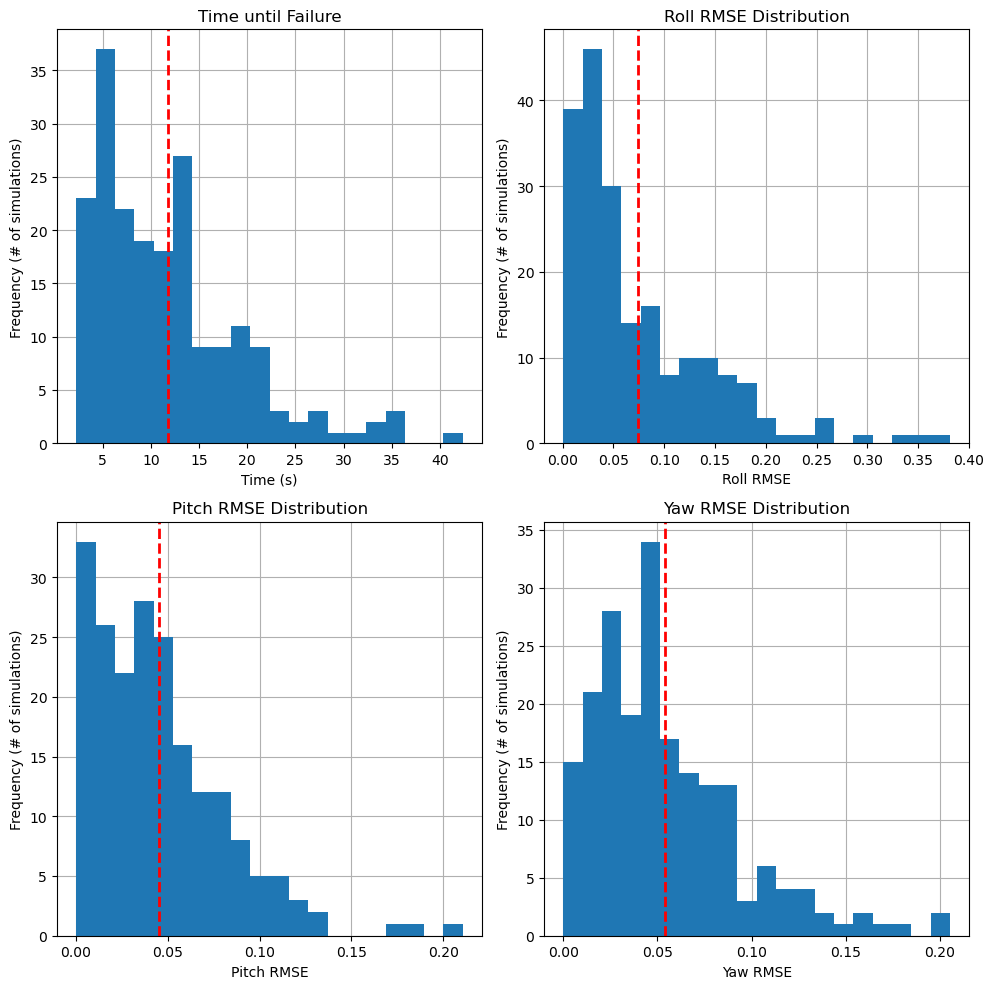

In [25]:
# Setting up the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10)) 

mean_time = np.mean(time)
mean_roll = np.mean(roll)
mean_pitch = np.mean(pitch)
mean_yaw = np.mean(yaw)

# Time histogram
axs[0, 0].hist(time, bins=20, zorder=2)
axs[0, 0].axvline(mean_time, color='r', linestyle='dashed', linewidth=2)
axs[0, 0].grid(zorder=0)
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('Frequency (# of simulations)')
axs[0, 0].set_title('Time until Failure')

# Roll RMSE histogram
axs[0, 1].hist(roll, bins=20, zorder=2)
axs[0, 1].axvline(mean_roll, color='r', linestyle='dashed', linewidth=2)
axs[0, 1].grid(zorder=0)
axs[0, 1].set_xlabel('Roll RMSE')
axs[0, 1].set_ylabel('Frequency (# of simulations)')
axs[0, 1].set_title('Roll RMSE Distribution')

# Pitch RMSE histogram
axs[1, 0].hist(pitch, bins=20, zorder=2)
axs[1, 0].axvline(mean_pitch, color='r', linestyle='dashed', linewidth=2)
axs[1, 0].grid(zorder=0)
axs[1, 0].set_xlabel('Pitch RMSE')
axs[1, 0].set_ylabel('Frequency (# of simulations)')
axs[1, 0].set_title('Pitch RMSE Distribution')

# Yaw RMSE histogram 
axs[1, 1].hist(yaw, bins=20, zorder=2)
axs[1, 1].axvline(mean_yaw, color='r', linestyle='dashed', linewidth=2)
axs[1, 1].grid(zorder=0)
axs[1, 1].set_xlabel('Yaw RMSE')
axs[1, 1].set_ylabel('Frequency (# of simulations)')
axs[1, 1].set_title('Yaw RMSE Distribution')

# Adjusting layout and displaying the plots
plt.tight_layout()
plt.show()

In [26]:
print("Average Simulation Run Time:", mean_time)
print("Average RMS Roll Error:", mean_roll)
print("Average RMS Pitch Error:", mean_pitch)
print("Average RMS Yaw Error:", mean_yaw)

Average Simulation Run Time: 11.76495000000003
Average RMS Roll Error: 0.07380126503738058
Average RMS Pitch Error: 0.045390007191398345
Average RMS Yaw Error: 0.0542789378071956


From the time histogram and the average simulation run time calculated below, the 200 trials ran for about 12.297 seconds before the simulation reached an end condition. Although there were multiple simulations that occurred before 10 seconds and few that made it to the end condition *No Debris Left*, this variation is due to the uncertainty of debris flying into the spacecraft during each trial. This uncertainty cannot be accounted for a single trial experiment, which is why the average simulation run time of 12.297 seconds is substantial enough to verify that Requirement 1 has been met.

From the histogram plots for RMSE orientation angles, the mean for Roll: 0.07976, Pitch: 0.05169, Yaw: 0.0558 are all less than the value of 0.1. This mathematical calculation along with the visual intepretation of the histograms verifies Requirement 2. In addition, the state estimate and state will be plotted against time to visualize this low RMSE for a single simulation. 

#### State Estimate and State

In [ ]:
# Resetting the simulator with initial conditions at equilibirum
sim = ae353_spacecraft.Spacecraft_Sim(use_keyboard=False,
                                      visualization=False,
                                      animation=False,
                                      n_stars=0)
# Resetting the controller
controller.reset()
    
# Running the simulation
data1 = sim.run(controller,
               initial_orientation=[0., 0., 0.],
               initial_ang_vel=[0., 0., 0.],
               sensor_noise=0.1,
               debris=True,
               max_time=150.0)
    
# Storing data into the arrays defined above
roll_test = np.array(data1['roll'])
pitch_test = np.array(data1['pitch'])
yaw_test = np.array(data1['yaw'])
time_test = np.array(data1['time'])
rollhat_test = controller.xhat_history["roll"]
pitchhat_test = controller.xhat_history["pitch"]
yawhat_test = controller.xhat_history["yaw"]

In [ ]:
# Setting up the figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Roll plot
axs[0].plot(time_test, rollhat_test, label='Roll Estimate', color='red')
axs[0].plot(time_test, roll_test, label='Roll', color='cyan', linestyle='--')
axs[0].legend()
axs[0].set_title('Roll Estimate vs Actual Roll')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Roll (rad)')
axs[0].grid(True)

# Pitch plot
axs[1].plot(time_test, pitchhat_test, label='Pitch Estimate', color='green')
axs[1].plot(time_test, pitch_test, label='Pitch', color='purple', linestyle='--')
axs[1].legend()
axs[1].set_title('Pitch Estimate vs Actual Pitch')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Pitch (rad)')
axs[1].grid(True)

# Yaw plot
axs[2].plot(time_test, yawhat_test, label='Yaw Estimate', color='orange')
axs[2].plot(time_test, yaw_test, label='Yaw', color='blue', linestyle='--')
axs[2].legend()
axs[2].set_title('Yaw Estimate vs Actual Yaw')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Yaw (rad)')
axs[2].grid(True)

# Adjusting layout and displaying the plots
plt.tight_layout()
plt.show()

From these graphs, it can be seen that the observer was able to predict a state estimate for the orientation angles somewhat accurately. However due to spacecraft being unable to control its momentum, the roll, pitch, and yaw angles became increasily more unstable as time went on. For roll, the estimated values deviated at a max difference of around 0.04. For pitch and yaw the max difference near the end of the simulation was around 0.08 and 0.025. These small errors are present due to the uncertainty of debris collisions with the spacecraft at random instances during the simulations causing the spacecraft to unexpectedly jostle in a certain direction. The observer is thus unable to predict these instantaneous changes. Overall, the observer was able to measure the orientation angles accurately with small error for roll, pitch and yaw, again supporting the verification of Requirement 2.

## Conclusion
This notebook discusses the implementation of a control system for a spacecraft under an star-tracker influence. With the implementation of a controller and an observer in this project, state estimates were used to apply actuator commands for a star tracker mechanism and a spacecraft. This enabled torque inputs on the spacecraft to induce a stable orientation that allowed the star tracking mechanism to monitor 8 stars. By testing external influences, like debris, the controller-observer mechanism was tested for its efficiency in maintaining the correct orientation. By setting requirements for the simulation to reach its desired state, the performance of the controller-observer system was quantified. Future work to test the validity of the controller-observer system could be done by testing different initial conditions including initial angle orientations or anglular velocities. More work could also be done in finding more ideal Q and R matrices for the controller and observer. With different initial yaw, pitch, and roll angles, or different weights, the controller may induce different torque responses onto the spacecraft. This change could help fully test the controller-observer's efficiency in attaining stability for the system.

## Acknowledgements

We would like to thank and acknowledge a number of people for providing advice during this project. Firstly, we would like to thank Shishir Bhatta for his insight in explaining how the controller and observer function together. Next, Graduate Assistant Pedro Leite for his comments and suggestions on DP 2. His insight provided much help towards improving the Theory, Experimental Methods, and overall formatting that was troubling previously. Finally, we would like to acknowledge Professor Chang for explaining the concepts necessary in completing this design project.

## Team Reflection

We were able to communicate effectively through Microsoft Teams by file sharing and sending images of our code. We kept in touch through Teams checking up on each others work, providing feedback and suggesting ideas that could fit into our controller/observer design. We communicated which tasks would be done by who and what areas still needed to be written. We took much inspiration from the Prarielearn Homeworks, Worksheets, and in-class Lecture notes to write this report and design an effective control system for the spacecraft. In addition to taking inspiration from materials in AE 353, we were able to learn a great deal from previous design projects. DP1 and DP2 were able to provide us with a valuable framework with which to perform our experiments and structure our code.

## References

[1] Saatci, T., and Zhang, C., "DP 2: Differential-Drive Robot in Artificial Gravity", Feb 2024
 
[2] Davidson, O., and Haque, K., "DP 2: Differential-Drive Robot in Artificial Gravity", Feb 2024
 
[3] Chang, W., "AE 353 Course Website", Apr 2024